# Лекция 4. Прерывания, системные вызовы, пользовательский ввод

1. Понятие прерывания.
2. Системные вызовы x86, x86-64 в Linux. Системные вызовы в Windows.
3. Пользовательский ввод в архитектурах x86, x86-64.
4. Некоторые полезные команды и механизмы.
5. Примеры программ на языке ассемблера: создание каталога, проверка чисел на простоту, числа Фибоначчи.

## 1. Понятие прерывания.

Для того чтобы операционная система могла защитить свои данные от пользовательских приложений и принимать данные от внешних устройств, процессор генерирует прерывания при нарушениях защиты и при получении сигналов от **контроллера прерываний**, который принимает сигналы от внешних и системных устройств. 

При генерации прерывания процессором текущая программа прерывается (отсюда и название); при этом сохраняются адрес следующей инструкции и регистр флагов, а управление передаётся обработчику. После своей работы обработчик возвращает управление прерванной программе, и её выполнение возобновляется как ни в чём не бывало. 

Прерывания бывают трёх видов:
1. Аппаратные.
2. Программные.
3. Исключения.

**Аппаратные прерывания** генерируются контроллером прерываний; их количество зависит от самого контроллера прерываний. 

**Программные прерывания** генерируются командой **INT n**. 

**Исключения** генерируются самим процессором при попытке нарушить ограничения защиты или при возникновении ошибок во время выполнения программы.

В режиме реальных адресов может существовать 256 различных прерываний. В начале памяти по адресу 0000:0000 расположена таблица прерываний, состоящая из 256 4-байтовых адресов в виде <dw сегмент>:<dw смещение>. 

Каждый такой адрес указывает на процедуру, обрабатывающую прерывание. Такие процедуры называются **обработчиками прерываний**, а адреса в этой таблице – **векторами**.

**В режиме реальных адресов исключений не было**, т. к. никакой защиты тоже не было. 

В защищённом режиме количество прерываний такое же, но таблица прерываний теперь может находиться по любому адресу и называется
**IDT (Interrupt Descriptor Table, таблица дескрипторов прерываний)**.

Каждое прерывание описывается не 4-байтовым адресом, а **дескриптором шлюза**. 

**Шлюз** – это специальный системный объект, который обеспечивает защиту и позволяет программам на разных уровнях использовать прерывания. Обычно обработчик прерывания находится на нулевом уровне привилегий, а вызывающий – выше, поэтому процессор как бы проходит через шлюз и опускается вниз на нулевой уровень привилегий, а после обработки поднимается вверх на уровень вызывающего.

Различают три типа шлюзов:
1. Шлюз задачи.
2. Шлюз прерывания.
3. Шлюз ловушки.

Еще бывают, так называемые, **маскируемые прерывания**. Бит IF регистра флагов отвечает за маскируемые прерывания. Если он очищен, то маскируемые прерывания игнорируются. Если он выставлен, то прерывания обрабатываются. Маскируемые прерывания называются так именно потому, что на них можно поставить маску и запретить. При сбросе флага IF запрещаются все маскируемые прерывания.

Физически **дескриптор шлюза** - это 8 байт, в которых последовательные биты сгруппированы по функциональному назначению.

|Биты|Назначение|
|----|----|
|0-15|зависит от типа шлюза|
|16-31|селектор|
|32-36|зарезервировано|
|37-39|зависит от типа шлюза|
|40-42|Тип шлюза|
|43|зависит от типа шлюза|
|44|всегда 0|
|45, 46|уровень привилегий дескриптора|
|47|бит присутствия|
|48-63|зависит от типа шлюза|

В случае, если генерируется прерывание, которое обрабатывается **шлюзом задачи**, происходит автоматическое переключение задачи. В битах 16–31 содержится **селектор TSS задачи**, на которую будет производиться переключение при использовании этого прерывания. 

В поле «тип шлюза» будут стоять значения 1, 0, 1 в битах 40, 41, 42 соответственно. Все остальные биты за исключением бита присутствия всегда равны нулю либо зарезервированы.

**Дескрипторы шлюза ловушки и дескрипторы шлюза прерывания** почти полностью идентичны. 

Отличие состоит лишь в том, что в битах типа шлюза у дескриптора шлюза ловушки будет стоять значение 111, а у шлюза прерывания – 110. 

В полях 16–31 находится **селектор сегмента кода**, в котором находится обработчик прерывания. В полях 0–15 и 48–63 находятся младшие и старшие 16 бит адреса обработчика прерывания. 

**При переходе через шлюз прерывания процессор автоматически сбрасывает флаг IF и тем самым не допускает генерации других прерываний на время работы обработчика, а для шлюза ловушки – не меняет состояние флага IF.** 

Ловушки используются для отладки программ, поэтому обработка ловушки должна быть прозрачна для внешних прерываний.

Бит 43 определяет размер шлюза: если он выставлен, то 32 бита; иначе 16 бит. Размер шлюза определяет размер стека, используемый процессором по умолчанию. Перед вызовом обработчика процессор помещает в стек значения регистров CS, EIP, EFLAGS и SS, ESP (если переход осуществился на другой уровень привилегий) и 16-битный код ошибки. Если размер шлюза – 32 бита, то значения размером в 16
бит будут расширены нулями до 32. 

Если 47 бит присутствия сброшен, то процессор понимает это как отсутствие обработчика и генерирует исключение общей защиты. 

45, 46 биты содержат максимальный уровень привилегий, с которого можно обратиться в этому шлюзу. Например, если в них содержится число 1, то вызвать данный шлюз (команда int <vector>) могут только программы, выполняющиеся на уровнях привилегий 0 и 1; вызов этого шлюза на уровнях 2 и 3 приведёт к исключению общей защиты.
    
Все дескрипторы объединяются в таблицу IDT. В этой таблице может быть от 0 до 256 дескрипторов. Параметры IDT задаются в регистре IDTR.

Команда **LIDT** загружает в регистр IDTR, **SIDT** сохраняет содержимое IDTR в память. 
    
Команда LIDT является привилегированной и может выполняться только на нулевом уровне привилегий; команда SIDT не является привилегированной. Для обеих этих команд операндом должны быть 6 байт в памяти.
    
**Исключения** генерируются самим процессором, когда какая-либо программа пытается нарушать ограничения защиты. Повлиять на исключения прикладные программы (работающие даже на нулевом уровне привилегий) не могут, замаскировать – тоже. Исключения процессора генерируются вне зависимости от флага IF.

Исключения делятся на три типа в зависимости от условий их возникновения:
1. **Ошибка** – это исключение, возникающее в ситуации ошибочных действий программы (подразумевается, что такую ошибку можно исправить). Такой тип исключения допускает рестарт команды, которая вызвала исключение после исправления ситуации, для чего в стеке обработчика адрес возврата из прерывания указывает на команду, вызвавшую исключение. Примером такого исключения может быть исключение отсутствующей страницы. Благодаря этому реализуется механизм виртуальной памяти, в частности подкачка данных с диска.
2. Ловушка – это исключение, возникающее сразу после выполнения «отлавливаемой» команды. Это исключение позволяет продолжить выполнение программы со следующей команды. На ловушках строится механизм отладки программ.
3. Авария – это исключение, которое не позволяет продолжить выполнение прерванной программы и сигнализирует о серьёзных нарушениях целостности системы. Примером аварии служит исключение двойного нарушения (прерывание 8), когда сама попытка обработки одного исключения вызывает другое исключение.

С целью корректного определения источника ошибки для некоторых исключений процессор помещает в стек 2-байтовый код ошибки. Исключений всего 32. 
    
    
**Аппаратные прерывания**
    
Посредником между устройствами и процессором служит контроллер прерываний, который можно назвать «диспетчером». Он позволяет процессору обрабатывать прерывания согласно приоритетам и избежать возможных коллизий при поступлении сигналов сразу от нескольких источников. В компьютере есть программируемый контроллер прерываний (PIC), который тесно взаимосвязан с процессором. На современных системах используется расширенный программируемый контроллер прерываний (APIC).
    
    
**Программные прерывания**
    
Прерывания можно генерировать программно. Команда INT генерирует прерывание. Число, указанное в качестве операнда, обозначает номер дескриптора в IDT, например: INT 25. 
    
Команда INT3 генерирует системное прерывание, которое вызывает прерывание 3. Команда INT3 имеет короткий опкод. 
    
Программные прерывания – это наиболее простой из методов вызова привилегированного кода для программ, которые работают на нулевом уровне привилегий. 
    
Пользовательские задачи обращаются к операционной системе через системные вызовы, которые реализованы через механизм **программных прерываний.** 

## 2. Системные вызовы x86, x86-64 в Linux. Системные вызовы в Windows.

Мы уже активно использовали некоторые системные вызовы Linux. Однако остановимся на этом вопросе более подробно.

Программировать полностью без системных вызовов в операционной системе нельзя. Она контролирует доступ ко всем аппаратным ресурсам и является своеобразным дирижером выполняемых программ и задач. Но если сильно хочется, то от операционной системы придется отказаться полностью. Такой подход известен как **Bare metal** — это платформа без операционной системы, которая позволяет программному обеспечению получать прямой доступ к аппаратной части. Например, с Bare metal программированием сталкиваются при программировании микроконтроллеров. 

Таким образом, если оставаться в рамках какой-то операционной системы и пытаться взаимодействовать с внешним миром с помощью языка ассемблера, то обращаться к системным вызовам придется. 

[**Системный вызов в операционной системе**](https://ru.wikipedia.org/wiki/%D0%A1%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D0%BD%D1%8B%D0%B9_%D0%B2%D1%8B%D0%B7%D0%BE%D0%B2#:~:text=%D0%A1%D0%B8%D1%81%D1%82%D0%B5%CC%81%D0%BC%D0%BD%D1%8B%D0%B9%20%D0%B2%D1%8B%CC%81%D0%B7%D0%BE%D0%B2%20(%D0%B0%D0%BD%D0%B3%D0%BB.,Linux%3A%20%D0%BE%D0%BA%D0%BE%D0%BB%D0%BE%20380%20%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D0%BD%D1%8B%D1%85%20%D0%B2%D1%8B%D0%B7%D0%BE%D0%B2%D0%BE%D0%B2.) можно определить как обращение прикладной программы к ядру операционной системы для выполнения какой-либо операции. 

Реализация системных вызовов осуществляется через **механизм прерываний**.

Во-первых, важно понимать, что **ядро операционной системы Linux полностью написано на языке программирования C, поэтому и описание системных вызовов идет в привязке к этому языку програмирования**.

Во-вторых, **для 32-bit и 64-bit систем Linux таблицы системных символов различны**. При этом системные вызовы 32-bit можно использовать в системах 64-bit, но не наоборот.

В третьих, **ядро операционной системы Windows закрыто, описание всех системных вызовов является корпоративной информацией и не входит в стандартные технические справочники**.


Системный вызов в 32-bit Linux реализуется через прерывание **int 0x80**, в 64-bit Linux для этих целей используется специальная команда **syscall**, предварительно в определенные регистры должна быть загружена требуемая информация.

Документацию по системным вызовам в привязке к языку C можно найти по следующей [ссылке](https://linuxdoc.ru/sys-doc.html).

Подробные таблицы системных вызовов в операционой системе Linux для различных архитектур можно найти по [ссылке](https://www.chromium.org/chromium-os/developer-library/reference/linux-constants/syscalls/) 

Некоторую информацию по системным вызовам Windows можно найти по ссылкам: [здесь](https://github.com/hfiref0x/SyscallTables)

Рассмотрим использование предложенных таблиц на ряде примеров: 

### **Системный вызов exit**

Его C-описание выглядит так:

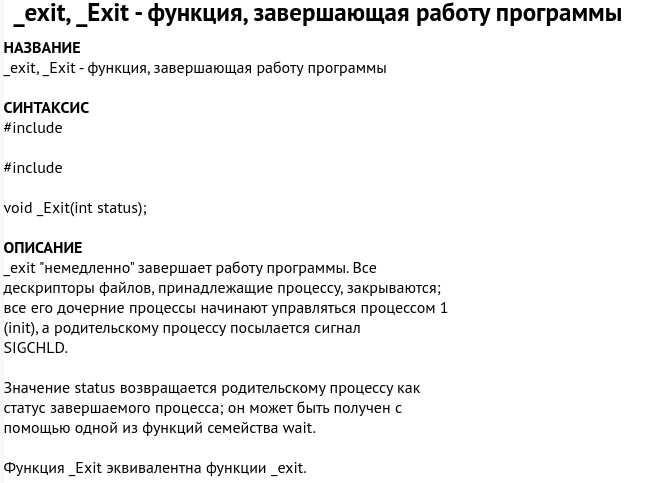

Таким образом, видно, что функция содержит один параметр **status** - это значение возвращается родительскому процессу как
статус завершаемого процесса.

Из подробной таблицы для 32-bit мы видим:

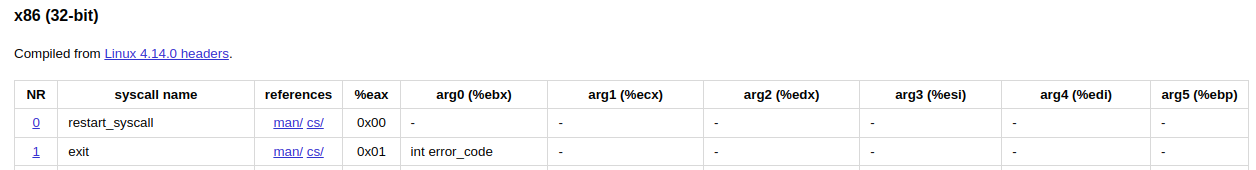

Номер этого системного вызова равен 1, это значение должно быть загружено в регистр **eax**, в тоже время параметр **status** соответствует значению регистра **ebx**, обозначенному как **arg0**.

Из этой таблицы видно, что для 32-bit Linux:
- в регистр **eax** загружается номер системного вызова;
- системное прерывание может иметь до 6 параметров, каждый из которых загружается в соответствующий регистр: **arg0(ebx), arg1(ecx), arg2(edx), arg3(esi), arg4(edi), arg5(ebp)** 

Таким образом, получаем уже известное нам:

In [ ]:
;Arch x86
mov eax, 1
mov ebx, 0
int 0x80

Всего в системной таблице 32-bit 439 вызовов (часть из них зарезервирована).

Теперь посмотрим на таблицу системных вызовов 64-bit:

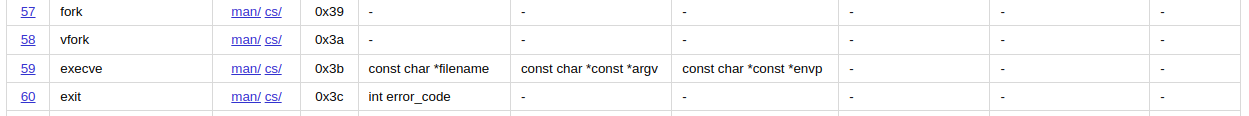

Как видно из таблицы, код (номер) этого вызова **0x3c** (в десятичном представлении 60) должен быть загружен в регистр **rax**, а значение параметра **status** в регистр **rdi**.

Таким образом, аналогичный приведенному выше код будет выглядеть следующим образом:

In [ ]:
;Arch x86-64
mov rax, 0x3c
mov rdi, 0
syscall

При использовании системного вызова в **x86-64** важно помнить: **при вызове гарантированно не сохраняются два регистра rcx – здесь хранится адрес возврата, r11 – в нем хранится регистр флагов**. 

Кроме того, в регистре rax возвращается код возврата. Т.е. если вы своей программе держите в регистрах rcx, r11 какие-либо важные величины, то перед системным вызовом их следует сохранить. Регистр же rax вы все равно используете для указания номера системной функции, но после вызова значение rax тоже меняется.


По приведенной выше ссылке также представлена таблица соответствия входных параметров системных вызовов и их регистров для различных архитектур ЦП:

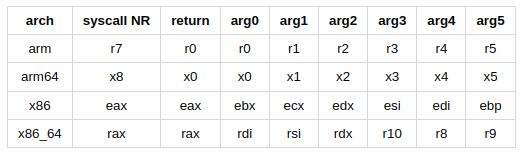

Здесь **syscall NR** - регистр, который используется для указания кода вызова (номера вызова),

**return** - указывает на регистр, который будет хранить код возврата.

Например, для архитектуры **arm64** для хранения параметров **arg0, arg1, arg2, arg3, arg4, arg5** используются соответственно регистры **x0, x1, x2, x3, x4, x5**, код вызова загружается в регистр **x8**.

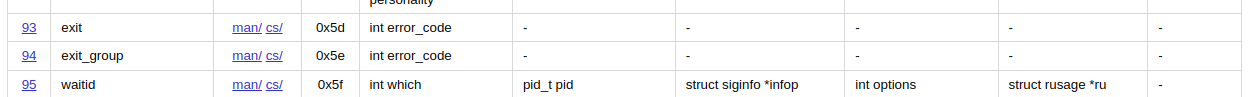

Cистемный вызов  **exit** будет выглядеть так:

In [ ]:
;Arch arm64
mov x8, 93
mov x0, 0
svc 0

### **Системный вызов write**

Теперь рассмотрим системный вызов **write**, через который мы реализовывали вывод информации на экран. 

Его С-описание выглядит так:

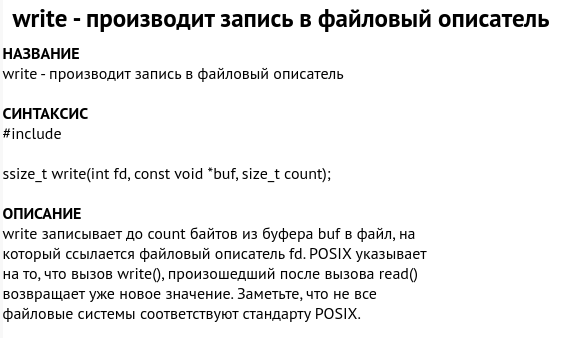



Итак, в описании мы видим три параметра:
- **fd** - дескриптор файла
- **buf** - указатель на буфер, откуда берется строка
- **count** - количество записываемых байтов

В таблице системных вызовов **x86** мы видим:

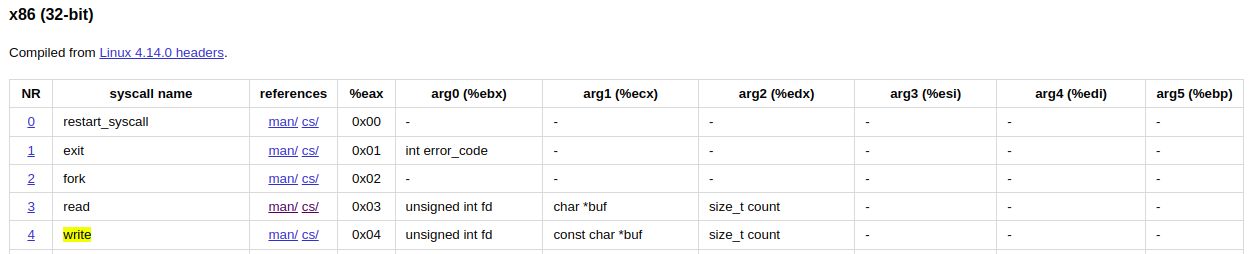

- в регистор **eax** загружаем номер системного вызова равный 4;
- в регистор **ebx** загружаем число 1, как дескриптор стандартного вывода - экран;
- в регистр **ecx** загружаем начальный адрес памяти, где хранится выводимая строка;
- в регистр **edx** загружаем количество выводимых символов.

В итоге код может выглядеть так:

In [ ]:
format elf
public _start
section '.data' writable
  mystr db "Hello", 0

section '.text' executable
_start:
  mov eax, 4
  mov ebx, 1
  mov ecx, mystr
  mov edx, 6
  int 0x80
  
  mov eax, 1
  mov ebx, 0
  int 0x80

В таблице системных вызовов **x86-64** мы видим:

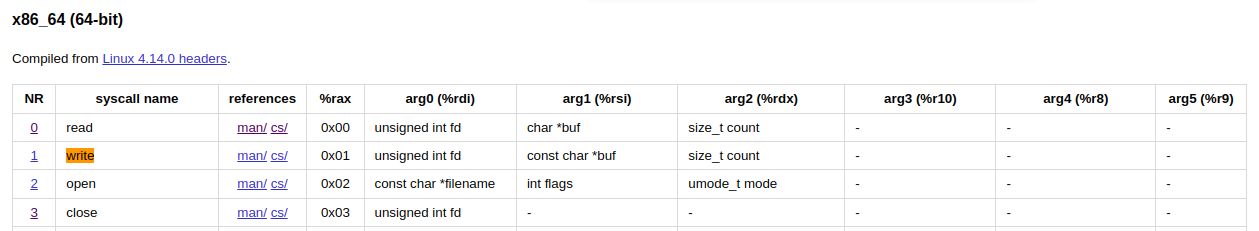

- в регистор **rax** загружаем номер системного вызова равный 1;
- в регистор **rdi** загружаем число 1, как дескриптор стандартного вывода - экран;
- в регистр **rsi** загружаем начальный адрес памяти, где хранится выводимая строка;
- в регистр **rdx** загружаем количество выводимых символов.

В итоге код может выглядеть так:

In [ ]:
format elf64
public _start
section '.data' writable
  mystr db "Hello", 0

section '.text' executable
_start:
  mov rax, 1
  mov rdi, 1
  mov rsi, mystr
  mov rdx, 6
  syscall
  
  mov rax, 60
  mov rdi, 0
  syscall

В таблице системных вызовов **arm64** мы видим:

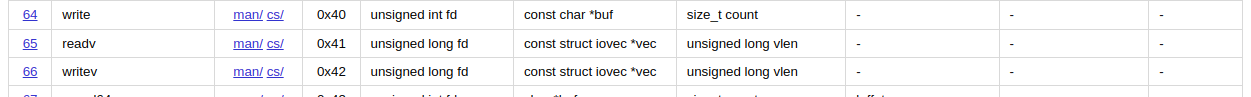

- в регистор **x8** загружаем номер системного вызова равный 64 (0x40);
- в регистор **x0** загружаем число 1, как дескриптор стандартного вывода - экран;
- в регистр **x1** загружаем начальный адрес памяти, где хранится выводимая строка;
- в регистр **x2** загружаем количество выводимых символов.

## 3. Пользовательский ввод в архитектурах x86, x86-64.

Рассмотрим теперь системный вызов ввода - **read**, который, например, позволяет осуществить ввод с клавиатуры.

Описание функции **read** в синтаксисе языка C:

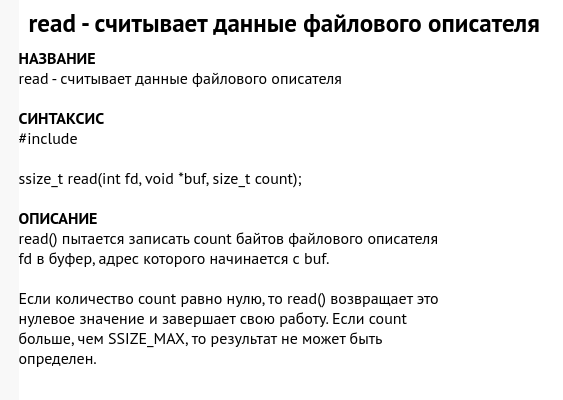

Из таблиц системных вызовов для разных архитектур имеем:

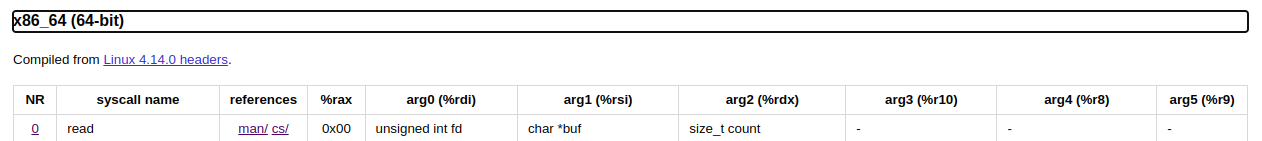

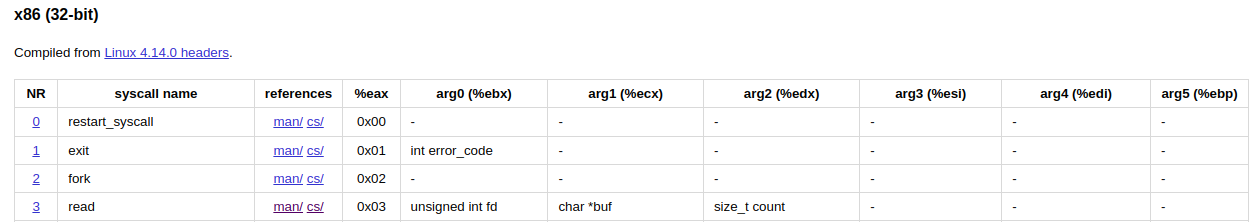

В архитектуре **x86-64** системная функция с номером 0 (**rax**) осуществляет чтение со стандартного устройства. При этом **rdi** – номер устройства, **rsi** – адрес буфера, **rdx** – длина буфера. 

Ввод заканчивается нажатием клавиши Enter. Если строка длиннее заданной длины буфера, то она обрезается по указанной длине. В регистре **rax** возвращается количество введенных байтов (не символов). Также в случае возникновения какой-либо ошибки в этом регистре возвращается отрицательная величина – номер ошибки с минусом.

В архитектуре **x86** системная функция с номером 3 (**eax**) осуществляет чтение со стандартного устройства. При этом **ebx** – номер устройства, **ecx** – адрес буфера, **edx** – длина буфера.

Для того, чтобы осуществить ввод именно с клавиатуры, нужно указать номер стандартного устройства ввода равным нулю (регистры **rdi**, **ebx**).

Рассмотрим ввод с клавиатуры на примере программы эхо-печати - с клавиатуры вводится строка и она тут же печатается на экран.

Заметим, что нам нужно резервировать память под вводимую строку. Поэтому вначале рассмотрим этот вопрос.

Для объявления и резервирования данных в fasm используются соответствующие директивы:

|Размер (в байтах)|Объявление|Резервирование|
|----|----|----|
|1|db|rb|
|2|dw(du)|rw|
|4|dd|rd|
|6|dp(df)|rp(rf)|
|8| dq|rq|
|10|dt|rt|
|N|file|  |

Резервировать память можно с помощью неинициализированных переменных.

**x1 db ?**

**x2 dw ?,?,?**

**x3 dd 10 dup(?)**

Кроме того, FASM поддерживает специальные директивы резервирования данных. Число после директивы обозначает количество резервируемых элементов. То же самое можно объявить вот так:

**x1 rb 1**

**x2 rw 3**

**x3 rd 10**

С неинициализированными переменными следует быть внимательным. Не надо рассчитывать, что по умолчанию значение будет нулевым или ещё каким-то, иначе это может привести к ошибке.

file — это особая директива объявления данных, которая позволяет добавить в исполняемый файл последовательность байтов из внешнего файла. Иногда это может быть очень удобно. Например, если вы хотите добавить изображение в исполняемый файл (в виде данных), или большой кусок текста, или даже код из другого файла. Директива используется следующим образом:

In [ ]:
data1 file 'data.bin'       ;Добавить файл data.bin целиком.
data2 file 'data.bin':20    ;Добавить байты из файла data.bin, начиная со смещения 20.
data3 file 'data.bin':20,5  ;Добавить 5 байтов из файла data.bin, начиная со смещения 20.

По умолчанию, число в программе воспринимается ассемблером как десятичное. Чтобы обозначить двоичное число, необходимо к нему в конце добавить символ ’b’. Восьмеричное число обозначается аналогично с помощью символа ’o’. Для записи шестнадцатеричного числа FASM поддерживает 3 формы записи:
- перед числом записываются символы ’0x’ (как в C/C++);
- перед числом записывается символ ’$’ (как в Pascal);
- после числа записывается символ ’h’. Если шестнадцатеричное число начинается с буквы, необходимо добавить в начале ноль (иначе непонятно, число это или имя метки).

Этот синтаксис используется как при объявлении данных, так и в командах. Вот примеры записи чисел во всех четырёх системах:

In [ ]:
mov ax,537          ;Десятичная система
 
mov bl,11010001b    ;Двоичная система
 
mov ch,57o          ;Восьмеричная система
 
mov dl,$C2          ;\
mov si,0x013A       ; \
mov ah,18h          ; / Шестнадцатеричная система
mov al,0FFh         ;/
 
mov al,FFh          ;Ошибка!

Перейдем теперь к реализации программ эхо-печати для разных архитектур порцессора.

In [ ]:
;;;The program demonstrates echo printing in architecture x86

format elf
public _start

section '.bss' writable
  msg rb 255

section '.text' executable
  _start:
  ;реализуем системный вызов чтения с клавиатуры
    mov eax, 3
    mov ebx, 0
    mov ecx, msg
    mov edx, 255
    int 0x80

   ;реализуем вывод на экран до достижения нулевого символа
    xor edx, edx
    xor eax, eax
   .loop:
    mov al, [msg+edx]
    cmp eax, 0
    je .next
    inc edx
    jmp .loop
   .next:
    mov eax, 4
    mov ebx, 1
    mov ecx, msg
    int 0x80
    
    ;реализуем корректное завершение программы
    mov eax, 1
    mov ebx, 0
    int 0x80

In [ ]:
;;;The program demonstrates echo printing in architecture x86-64

format elf64
public _start

section '.bss' writable

   msg rb 255

section '.text' executable

_start:
   mov rax, 0
   mov rdi, 0
   mov rsi, msg
   mov rdx, 255
   syscall

   xor rdx, rdx
   xor rax, rax
.loop:
   mov al, [msg+rdx]
   cmp rax, 0
   je .next
   inc rdx
   jmp .loop
.next:
   mov rax, 1
   mov rdi, 1
   mov rsi, msg
   syscall

   mov rax, 60
   mov rdi, 0
   syscall

## 4. Некоторые полезные команды и механизмы.

**Циклические конструкции**

Команда **LOOP** принимает в качестве единственного операнда ближнюю метку. Она уменьшает регистр ECX (CX, RCX) на единицу и, если этот регистр не равен нулю, то происходит передача управления метке. Единственное преимущество этой команды состоит лишь в том, что она занимает меньше места.

Ниже приведены сравнительные примеры. 

In [ ]:
format elf64
public _start

include 'func.asm'

section '.data' writable

msg db "Hello", 0x0A,0


_start:
   mov rcx, 10
   mov rsi, msg
   .lab1:
     call print_str
   loop .lab1
   call exit

In [ ]:
format elf64
public _start

include 'func.asm'

section '.data' writable

msg db "Hello", 0x0A,0


_start:
   mov rcx, 10
   mov rsi, msg
   .lab1:
     call print_str
     dec rcx
     cmp rcx, 0
     jne .lab1
   call exit

Также есть две команды организации циклов: **LOOPE (LOOPZ) и LOOPNE (LOOPNZ)**. 

Команда **LOOPE** перед передачей управления проверяет флаг ZF и, если он не выставлен, то передачи управления не происходит. 

Обратное действие производит команда **LOOPNE**: если флаг ZF выставлен, то передачи управления не происходит.


На современных процессорах организация цикла с помощью команд DEC/ JNZ/JZ предпочтительна с точки зрения производительности; в сумме они будут работать в два раза быстрее, нежели одна инструкция LOOP.

**Макросы**

К макросредствам ассемблера Fasm относятся **константы, макросы и структуры**.

Константы можно объявить несколькими способами. Первый способ – это объявление имени константы и определение её значения через знак равенства. Этим способом можно объявлять константы в любом месте, и они будут доступны в любом месте программы. При использовании константы в программе на её месте будет поставлено её значение.

Второй способ объявления констант –  через директиву EQU. 

In [ ]:
_С = 45;
_name = 0A1h
Value = "S"; тоже самое что и Value = 53h
CONST1 equ 0123h
CONST2 equ 14d*15h
CONST3 equ "slovo"
CONST4 equ 56-45
CONST5 equ (metka1)
CONST6 equ (metka2+ metka3)
CONST7 equ (CONST2+10b)
CONST8 equ CONST7/2
CONST9 equ (metka1-metka5)
CONST10 equ (metka4+CONST4)
CONST11 equ add edx,edi

Из примеров  видно, что константе можно присвоить значение метки (т. е. её адрес) и даже некоторую команду. Если константа определена как команда, то она не может использоваться как операнд; её можно указать просто одиночно, и при этом она будет заменена своим значением. 

Вообще во всех случаях определения констант при применении константы она будет заменена своим значением. Тем не менее у директив = и equ есть два существенных отличия.

In [ ]:
C1 = 10
C2 equ 2
C3 equ C1+C2
C4 = C1+C2
mov eax, C3 ; mov eax, C1+C2
mov eax, C4 ; move ax, 12

При использовании директивы = значение константы вычисляется сразу и при подстановке вставляется вычисленное значение. А при использовании equ значение константы не вычисляется и просто заменяется её определением при использовании.

Таким образом, подстановочное значение константы, объявленной с помощью директивы equ, может изменяться.

**Макрос** – это более «продвинутый» вариант директивы equ. Макрос – это набор инструкций.
Макросы объявляются следующим образом:

In [ ]:
macro <имя макроса> <параметры макроса>

{

<тело макроса>

}

Потом при каждом упоминании имени макроса оно будет заменено телом макроса, где бы он ни использовался. 

Вот один из примеров макроса:

**macro tst {cmp eax,ebx}**

Теперь можно использовать инструкцию TST в любом месте после её определения, и она будет ассемблирована как cmp eax,ebx.

Определение константы с таким значением даст похожий результат; различие лишь в том, что имя макроинструкции будет распознаваться  как команда ассемблера. 

Если вы определите макроинструкцию и константу под одним и тем же именем и используете это имя как мнемоник инструкции, оно будет заменено содержанием макроинструкции, но если вы используете его внутри операндов, имя будет заменено значением константы.

Ниже представлен пример макроса с тремя параметрами:

In [ ]:
macro mov op1,op2,op3
{
if op3 eq
mov op1,op2
else
mov op1,op2
mov op2,op3
end if
}

Директива **if** производит условное ассемблирование. Если условие выполняется, то ассемблируется блок инструкций после
неё до следующей команды **end if, else или elseif**. Директива **else** ассемблирует блок инструкций, если не были выполнены все предыдущие условия. Директива **elseif** ассемблирует блок инструкций, если будет выполнено условие и если
не будут выполнены все предыдущие условия. Директива **end if** заканчивает всю цепь инструкций **if**. 

Директива **eq** проверяет операнды на тождественность; они могут быть записаны в разных формах. В нашем случае она проверяет, определен ли op3 вообще, и если определен, то производится действие op1 = op2, op2 = op3.
После этого при использовании

**mov eax, ebx, edx**

произойдет замена на

**mov eax, ebx**

**mov ebx, edx**

Если будут указаны только два операнда, то произойдет замена на обычную команду mov.

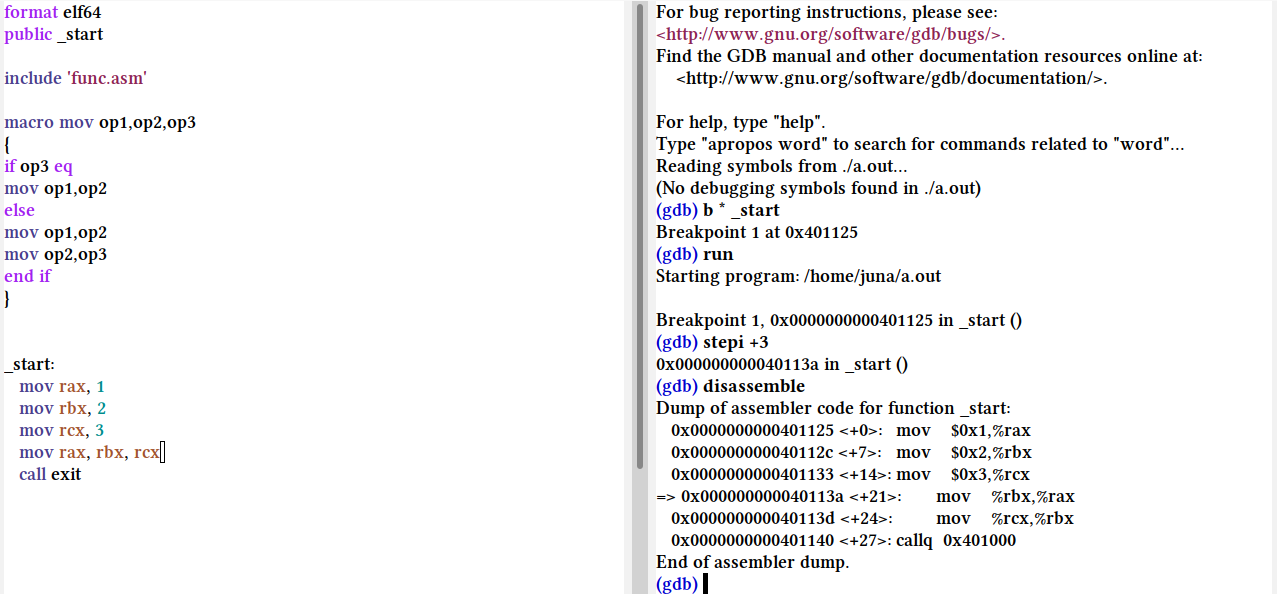

**Структуры**

**Структура** – это набор переменных (данных). Структура задаётся с помощью директивы **STRUC**. 

Пример объявления структуры:

In [ ]:
Struc sample
{
.x1 dd ?
.y1 dw ?
.y2 db ?
}

Теперь после объявления структуры можно определить переменную и использовать её поля:

In [ ]:
...
_Var sample
...
mov ax, [_Var.y1]

При использовании полей структуры выражение заменяется адресом равным смещению переменной плюс смещение поля в самой структуре.

In [ ]:
...
_Var sample
...
mov ax, [_Var.y1]

Аналогичная запись:

mov ax, word [_Var+4]

Если требуется задавать значения полей и эти значения заранее неизвестны, то можно воспользоваться параметрами, как при использовании макросов:

In [ ]:
struc numbers x,y
{
.x1 dd x
.y1 dw ?
.y2 db y
}

После этого, объявляя переменную, надо обязательно указать все параметры:

In [ ]:
...
_Var numbers 34, 67
...
mov ax, [_Var.y1]

**Команда CPUID**

Команда CPUID используется для идентификации процессора. С помощью этой команды можно узнать, на каком типе процессора работает наша программа, какие технологии поддерживает процессор.

Команда CPUID возвращает в регистры EAX, EBX, ECX, EDX информацию в зависимости от того, какой тип информации был указан в регистре EAX (иногда ещё и в регистре ECX). 

In [ ]:
format elf64
public _start

include 'func.asm'
message db 49 dup (0)

_start:
mov edi, message
mov eax, 80000002h
cpuid
mov [edi], eax
add edi, 4
mov [edi], ebx
add edi, 4
mov [edi], ecx
add edi, 4
mov [edi], edx
add edi, 4
mov eax, 80000003h
cpuid
mov [edi], eax
add edi, 4
mov [edi], ebx
add edi, 4
mov [edi], ecx
add edi, 4
mov [edi], edx
add edi, 4
mov eax, 80000004h
cpuid
mov [edi], eax
add edi, 4
mov [edi], ebx
add edi, 4
mov [edi], ecx
add edi, 4
mov [edi], edx
mov rsi, message
call print_str
call new_line
call exit

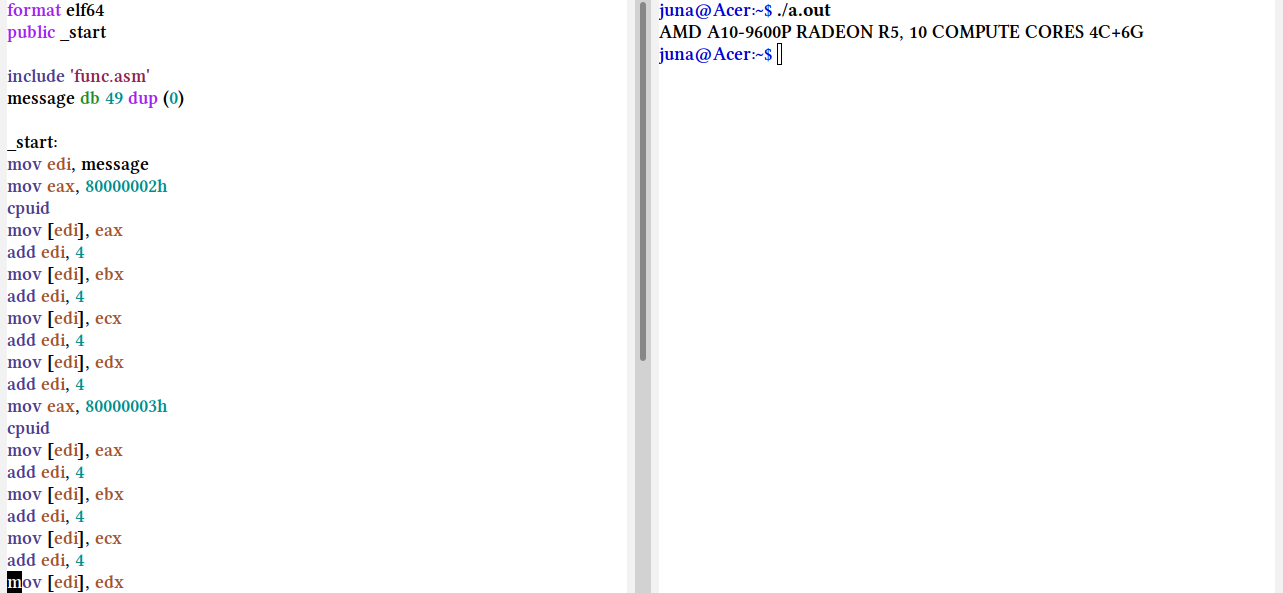


Если указан тип информации 80000002h, то мы получим первые 16 байт строки названия процессора. Эта строка будет содержаться в регистрах EAX, EBX, ECX, EDX в указанном порядке. 

Для получения следующих 16 байт строки названия процессора надо вызвать команду CPUID, указав тип информации равный 80000003h. 

Для получения последних 16 байт строки названия процессора надо указать тип информации 80000004h.

## 5. Примеры программ на языке ассемблера: создание каталога, проверка чисел на простоту, числа Фибоначчи.

### Создание каталога с заданным именем

Для демонстрации использования системных вызовов разработаем программу, в которой вводится имя файла и создается каталог с этим именем.

Для задания имени каталога используем ввод с клавиатуры, для создания каталога используем системный вызов **mkdir** (для архитектуры x86-64 он имеет номер 83).  Синтаксис этой команды в привязке к С выглядит следующим образом:

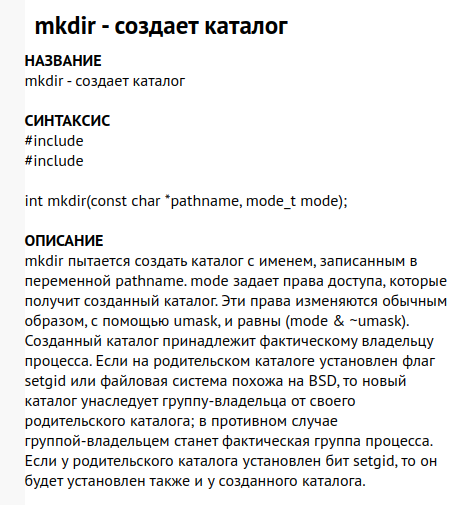

Таким образом, в первый параметр передается имя каталога, второй параметр определяет права доступа к каталогу. Однако в формировании прав доступа участвует еще системный вызов **umask** (для архитектуры x86-64 он имеет номер 95). Синтаксис этой команды в привязке к С выглядит следующим образом:

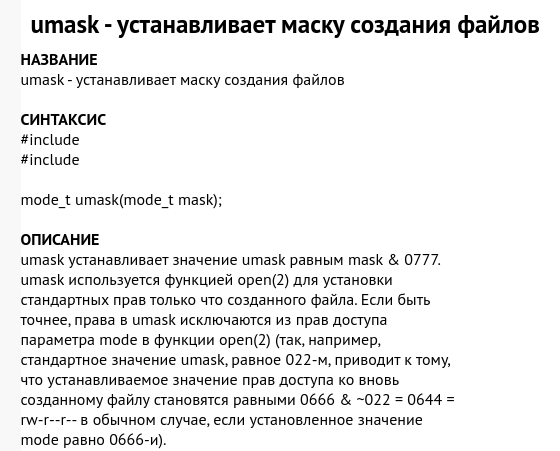

Сооветственно в таблице системных вызовов x86-64 имеем:

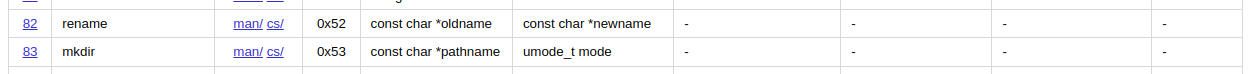

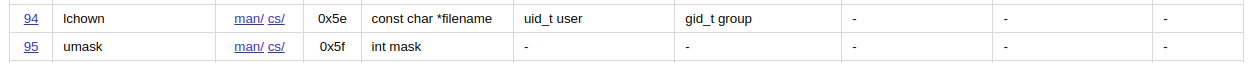

Системный вызов **umask** устанавливает маску прав, которая применяется к вновь создаваемым файлам путем ее вычитания из значения переменной **mode** системного вызова mkdir.

Иными словами, если, например, установить маску в значение $000000001b$, а значение **mode** взять равным $111111111b$, то в итоге получим права $111111110=rwxrwxrw-$.

In [ ]:
;;;The program demonstrates makimg of directory and getting rigth of the file in architecture x86-64

format elf64
public _start

section '.bss' writable

msg rb 255

section '.text' executable
_start:

;системный вызов read
   mov rax, 0
   mov rdi, 0
   mov rsi, msg
   mov rdx, 255
   syscall

;системный вызов umask
   mov rax, 95
   mov rdi, 000000001b
   syscall

;системный вызов mkdir
   mov rax, 83
   mov rdi, msg
   mov rsi, 111111111b
   syscall

;системный вызов exit
   mov rax, 60
   mov rdi, 0
   syscall


После запуска программы можно заметить, что при вводе имени файла код символа Enter также попадает в имя создаваемого каталога. На практике это нужно исключить. Для этого достаточно пробежаться по строке и заменить код символа Enter на символ конца строки нуль.

Для просмотра, что же записывается по адресу переменной **msg** после ввода строки - имени файла используем отладчик **gdb**.

Запускаем как обычно отладчик с указанием на исполняемый файл:

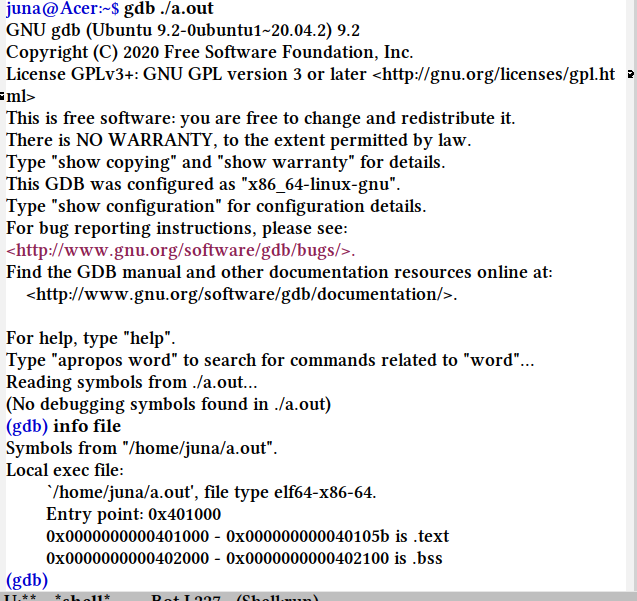

Чтобы получить информацию о секциях в исполняемом файле и их адресах, используем команду:

> **info file**

Итак, мы видим, что точка входа имеет адрес Entry point: 0x401000, формат исполняемого файла: elf64-x86-64, в файле секция кода располагается по адресам: 0x0000000000401000 - 0x000000000040105b is .text, секция .bss располагается по адресам: 0x0000000000402000 - 0x0000000000402100 is .bss

Для того, чтобы поменять нотацию ассемблера с AT&T  на intel, используем команду:

> set disassembly-flavor intel

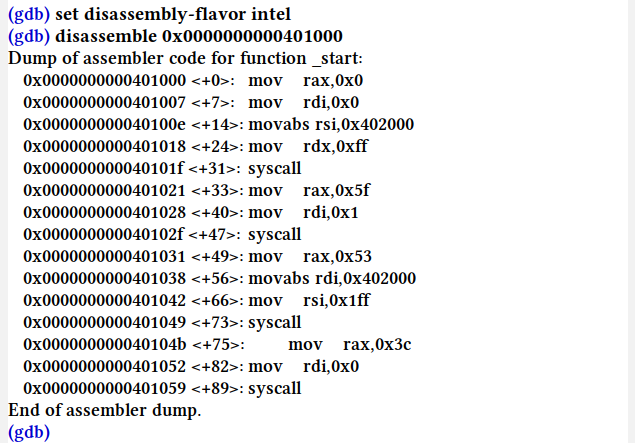

Чтобы дизассемблировать код с указанного адреса, можно использовать команду:

> disassemble address
    
В этом случае код будет дизассемблирован до конца исполняемого файла. Можно дизассемблировать с заданного адреса до плюс к указанному адресу заданное количество байт, или до заданного адреса:
    
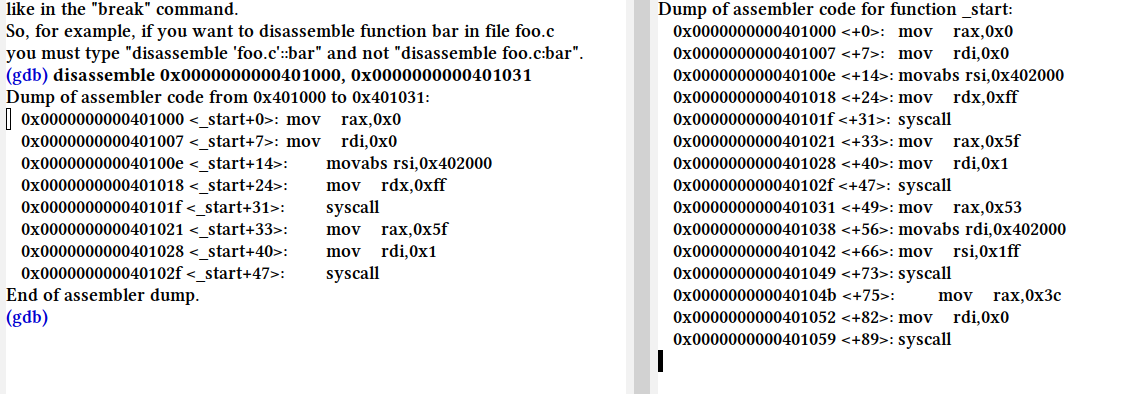

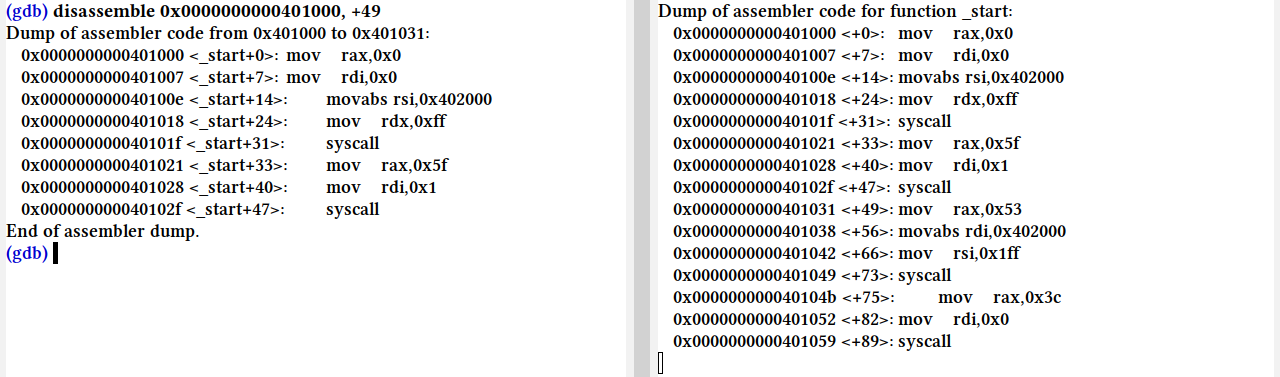

Сделаем точку останова и запустим программу. Выполним ее в пошаговом режиме до первого системного вызова:

Чтобы сделать точку останова, можно использовать сокращенный вариант команды **break**:

> b * point

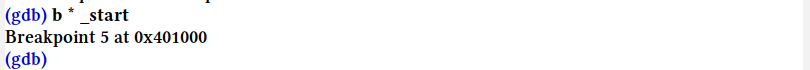

Чтобы посмотреть информацию о созданных точках останова, можно использовать команду:

> info breakpoints

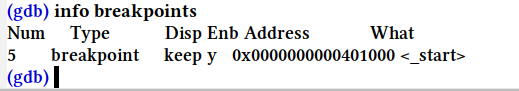

Чтобы удалить заданную точку, можно использовать команду:

> del number

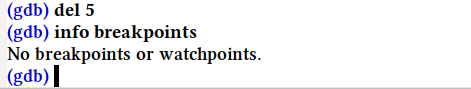

Чтобы запустить программу до заданной инструкции, можно использовать команду:

> stepi +number

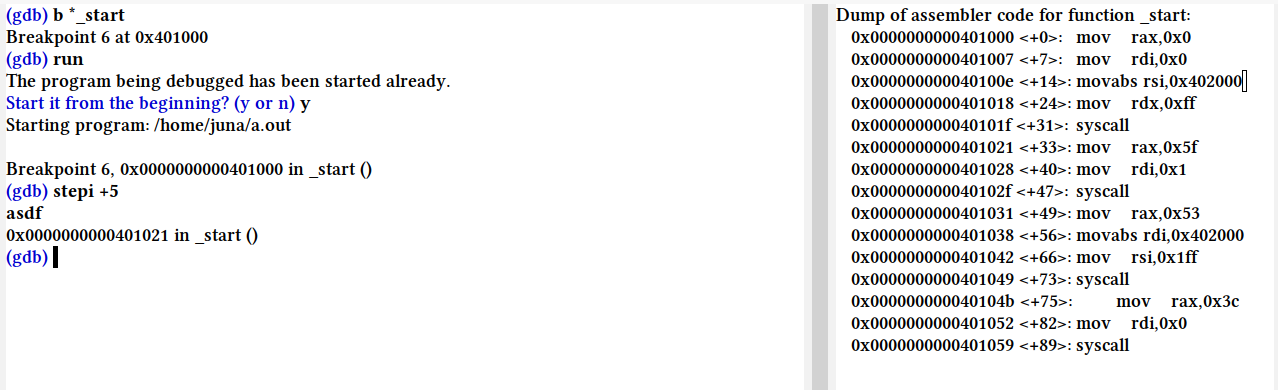

Как видно, первый системный вызов - это пятая инструкция, поэтому используем **stepi +5**.

Для того, чтобы с заданного адреса памяти получить массив записанных туда чисел, можно использовать команду:

> x/number xb address

Здесь **number** - количество выводимых элементов, **x** - в шестнадцатирисчном представлении, **b** -  побайтно, **address** - адрес начала дампа памяти:

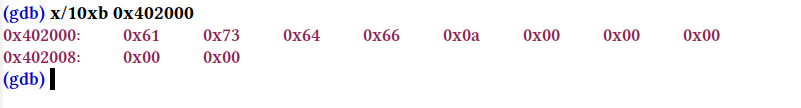

В приведенном примере мы выводим первые 10 байт по адресу 0x402000, куда записывается введенная с клавиатуры строка. Мы видим, что перед нулевыми значения стоит код 0x0A - ASCII код Enter.

Модифицируем нашу программу, удалив его.

In [ ]:
;;;The program demonstrates echo printing in architecture x86-64

format elf64
public _start

section '.bss' writable

  msg rb 255

section '.text' executable
_start:
  mov rax, 0
  mov rdi, 0
  mov rsi, msg
  mov rdx, 255
  syscall

  xor rcx, rcx
  .loop:
     mov al, [msg+rcx]
     inc rcx
     cmp rax, 0x0A
     jne .loop
  dec rcx
  mov [msg+rcx], 0

  mov rax, 95
  mov rdi, 000000001b
  syscall

  mov rax, 83
  mov rdi, msg
  mov rsi, 111111111b
  syscall

  mov rax, 60
  mov rdi, 0
  syscall


Смотрим на результат в gdb:

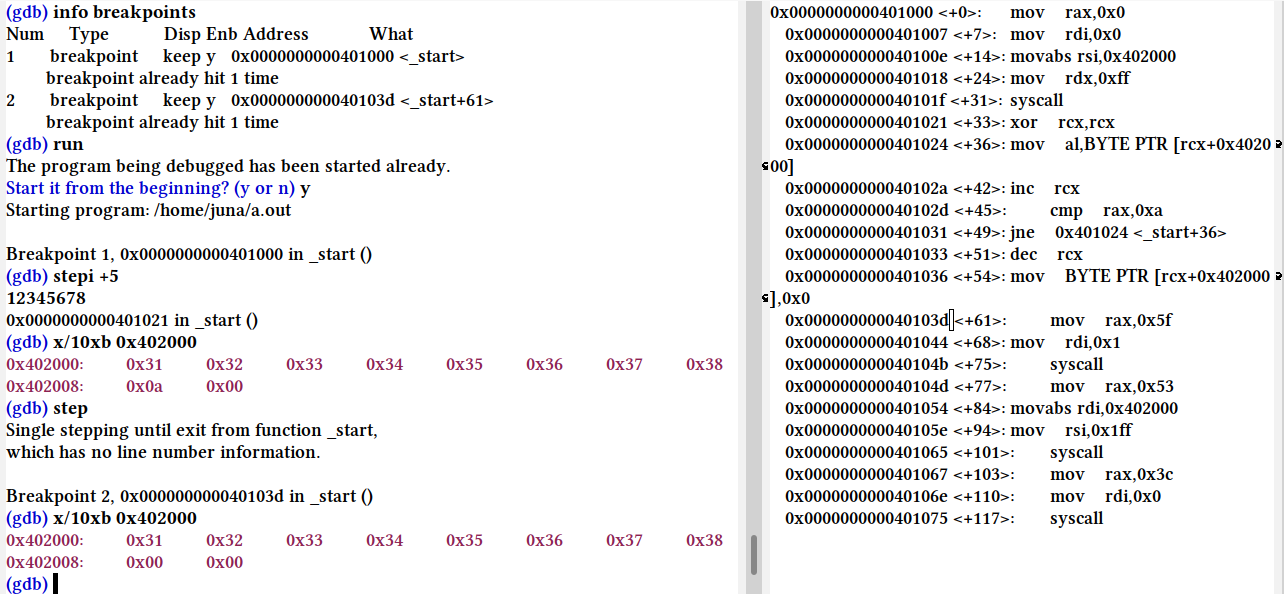



Итак, вначале мы добавили еще одну точку останова на адресе 0x000000000040103d. Это видно по результату выполнения команды **info breakpoints**.

После запуска программы командой **run**, мы выполнили первые 5 инструкций командой **stepi +5** и посмотрели дамп памяти по адресу  0x402000 командой x/10xb 0x402000. Здесь видно, что в памяти присутствует код Enter.

Далее с помощью команды **step** мы выполнили программу до следующей точки останова по адресу 0x000000000040103d и еще раз посмотрели дамп памяти - теперь видно, что ASCII код Enter заменен на нуль.

Таким образом, теперь программа работает исправно.

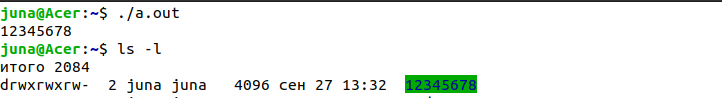



## Проверка чисел на простоту

Реализуем простейший алгоритм проверки чисел на простоту. Предварительно усовершенствуем нашу библиотеку функций, добавив туда функцию ввода с клавиатуры и переписав все функции для архитектуры x86-64.

Библиотеку назовем **func.asm**

In [ ]:
;;My library of useful functions named func.asm

;Function exit
exit:
     mov rax, 60
     mov rdi, 0
     syscall

;Function printing of string
;input rsi - place of memory of begin string
print_str:
    push rax
    push rdi
    push rdx
    push rcx
    mov rax, rsi
    call len_str
    mov rdx, rax
    mov rax, 1
    mov rdi, 1
    syscall
    pop rcx
    pop rdx
    pop rdi
    pop rax
    ret

;The function makes new line
new_line:
   push rax
   push rdi
   push rsi
   push rdx
   push rcx
   mov rax, 0xA
   push rax
   mov rdi, 1
   mov rsi, rsp
   mov rdx, 1
   mov rax, 1
   syscall
   pop rax
   pop rcx
   pop rdx
   pop rsi
   pop rdi
   pop rax
   ret


;The function finds the length of a string
;input rax - place of memory of begin string
;output rax - length of the string
len_str:
  push rdx
  mov rdx, rax
  .iter:
      cmp byte [rax], 0
      je .next
      inc rax
      jmp .iter
  .next:
     sub rax, rdx
     pop rdx
     ret


;Function converting the string to the number
;input rsi - place of memory of begin string
;output rax - the number from the string
str_number:
    push rcx
    push rbx

    xor rax,rax
    xor rcx,rcx
.loop:
    xor     rbx, rbx
    mov     bl, byte [rsi+rcx]
    cmp     bl, 48
    jl      .finished
    cmp     bl, 57
    jg      .finished

    sub     bl, 48
    add     rax, rbx
    mov     rbx, 10
    mul     rbx
    inc     rcx
    jmp     .loop

.finished:
    cmp     rcx, 0
    je      .restore
    mov     rbx, 10
    div     rbx

.restore:
    pop rbx
    pop rcx
    ret

;The function converts the nubmer to string
;input rax - number
;rsi -address of begin of string
number_str:
  push rbx
  push rcx
  push rdx
  xor rcx, rcx
  mov rbx, 10
  .loop_1:
    xor rdx, rdx
    div rbx
    add rdx, 48
    push rdx
    inc rcx
    cmp rax, 0
    jne .loop_1
  xor rdx, rdx
  .loop_2:
    pop rax
    mov byte [rsi+rdx], al
    inc rdx
    dec rcx
    cmp rcx, 0
  jne .loop_2
  mov byte [rsi+rdx], 0   
  pop rdx
  pop rcx
  pop rbx
  ret


;The function realizates user input from the keyboard
;input: rsi - place of memory saved input string 
input_keyboard:
  push rax
  push rdi
  push rdx

  mov rax, 0
  mov rdi, 0
  mov rdx, 255
  syscall

  xor rcx, rcx
  .loop:
     mov al, [rsi+rcx]
     inc rcx
     cmp rax, 0x0A
     jne .loop
  dec rcx
  mov byte [rsi+rcx], 0
  
  pop rdx
  pop rdi
  pop rax
  ret

Теперь реализуем проверку чисел на простоту:

In [ ]:
;The function defines the prime number
;input rax - the number
;output rdi - 1 - prime number, 0 - composite number

is_prime:
  push rax
  push rbx
  push rcx
  push rdx

  cmp rax, 2
  je .a1
  
  mov rbx, 2
  mov rdi, rax
  xor rdx, rdx
  div rbx
  mov rcx, rax

  .loop:
    mov rax, rdi
    xor rdx, rdx
    div rbx
    inc rbx
    cmp rdx, 0
    je .a2
    cmp rcx, rbx
    jge .loop
  .a1:
    mov rdi, 1
    jmp .a3
  .a2:
    mov rdi, 0
    jmp .a3
  .a3:
    pop rdx
    pop rcx
    pop rbx
    pop rax
    ret

Объединим все в один исполняемый файл:

In [ ]:
format elf64
public _start
public is_prime

include 'prime.asm'
include 'func.asm'

section '.bss' writable
  place rb 255
  answer rb 2

_start:
  mov rsi, place
  call input_keyboard
  call str_number
  call is_prime
  mov rax, rdi
  mov rsi, answer
  call number_str
  call print_str
  call new_line
  call exit

## Вычисление числа Фибоначчи

Как известно, число Фибаначчи определяется рекурсивно:
$$Fib(n) = Fib(n-1)+Fib(n-2), Fib(1)=Fib(2)=1$$

Программа должна для заданного $n$ вычислять число Фибоначчи. Опять реализуем это в виде функции.

In [ ]:
;;;The function evaluates the n's Fibonachi number
;;;input rax - number n
;;;output rdx - the n's Fibonachi number
fibonachi:
  push rax
  push rbx
  push rcx

  mov rcx, rax
  cmp rcx, 1
  je .a1
  cmp rcx, 2
  je .a1

  mov rax, 1
  mov rbx, 1
  dec rcx
  .loop:
     mov rdx, rax
     add rax, rbx
     mov rbx, rdx
     dec rcx
     cmp rcx, 0
     je .a2
    jmp .loop
  .a1:
    mov rdx, 1
    jmp .a2
  .a2:
    pop rcx
    pop rbx
    pop rax
    ret

Окончательно получаем:

In [ ]:
format elf64
public _start

include 'fib.asm'
include 'func.asm'

section '.bss' writable
  place rb 255
  answer rb 2

_start:
  mov rsi, place
  call input_keyboard
  call str_number
  call fibonachi
  mov rax, rdx
  mov rsi, answer
  call number_str
  call print_str
  call new_line
  call exit